<a href="https://colab.research.google.com/github/KiltCross/Line-Fuser/blob/master/Fusor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
print(tf.__version__)

!pip install --upgrade tensorflow

from tensorflow.keras import layers

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [0]:
import IPython.display as display

import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio

import math 


from IPython import display

import the images part.

In [0]:
train_X_1=[[1.0,1.0,1.0],[0.0,0.0,0.0],[0.0,0.0,0.0]]
train_X_2=[[1.0,0.0,0.0],[1.0,0.0,0.0],[1.0,0.0,0.0]]
train_X_temp=np.transpose(
    np.array(
    np.concatenate(
        (
        np.transpose(train_X_1) , np.transpose(train_X_2)
        )
    ), dtype='float32')
)
train_Y_temp = np.array([[1,0,0],[0,1,0],[0,0,1]], dtype='float32')



#Adapting the variables for the "fit" process
#The framework only acept batch of three dimension, and The model only use two-dimensional batches,
#so I decided to duplicate the images, for have three-dimensional batches

train_X = np.array((train_X_temp), dtype='float32')
train_Y = np.array([[[train_Y_temp[0,:], train_Y_temp[1,:], train_Y_temp[2,:]]]], dtype='float32').reshape(1,3,3,1)

negative_train_Y = train_Y * -1 + 1

#train=np.array((train_1,train_2), dtype='float32')

print(train_X)

Model builder

In [0]:
#@title
def generator_model():

  primaty_activation_function='sigmoid'

  model = tf.keras.Sequential()
  model.add(layers.Dense(9, input_shape=(3,6), name='1', activation=primaty_activation_function, use_bias=False))
  model.add(layers.Reshape((3,3,1)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Dense(180, activation=primaty_activation_function, use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Dense(300,activation=primaty_activation_function, use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(400, (5, 5), strides=(1, 1), padding='same', use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(200, (5, 5), strides=(1, 1), padding='same', use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Dense(3,activation='softmax', use_bias=False))

  model.add(layers.Conv2DTranspose(1, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))


  return model

In [0]:
def discriminator_model():

  primaty_activation_function='sigmoid'

  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[3, 3, 1]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(1))


  return model

Model functionality test:

In [0]:
generator = generator_model()

discriminator = discriminator_model()

#discriminator.summary()

#generator.summary()

generated_image = generator(train_X_temp, training=False)

result = discriminator(generated_image, training=False)

plt.imshow(generated_image[0,:,:,0], cmap='gray')

print(generated_image[0,:,:,0])

#print(train_X)


NameError: ignored

Setting some useful varibles

In [0]:
Epoch=1000

generator_optimizer = tf.keras.optimizers.Adam(1e-4)

discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

mean_squared = tf.keras.losses.mean_squared_error

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


Setting the generator loss

In [0]:
def generator_loss_function(fake_output, real_image, fake_image, negative_image):
    real_loss = cross_entropy(real_image[0,:,:,0], fake_image[0,:,:,0])
    fake_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    negative_loss = cross_entropy(negative_image[0,:,:,0], fake_image[0,:,:,0])**-1
    total_loss = real_loss + fake_loss + negative_image
    return total_loss

Setting the discriminator loss

In [0]:
def discriminator_loss_function(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

Train function part 1 of 2:

In [0]:
#@title
@tf.function
def train_step(image_X, image_Y, image_negative_Y):
    with tf.GradientTape() as generator_tape, tf.GradientTape() as discriminator_tape:

      generated_images = generator(image_X, training=True)

      real_output = discriminator(image_Y, training=True)
      fake_output = discriminator(generated_images, training=True)

      generator_loss = generator_loss_function(fake_output, image_Y, generated_images, image_negative_Y)
      discriminator_loss = discriminator_loss_function(real_output, fake_output)
      print(generator_loss)


      #Here I use the a inverse loss function to make the model move away from the negative examples

    gradients_of_generator = generator_tape.gradient(generator_loss, generator.trainable_variables)

    gradients_of_discriminator = discriminator_tape.gradient(discriminator_loss, discriminator.trainable_variables)


    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    #optimizer.minimize(loss, generator.trainable_variables)

 


Train function part 2 of 2:

In [0]:
def train(images_X, images_Y, images_negative_Y, epochs):
  for epoch in range(epochs):
    start = time.time()
    train_step(images_X, images_Y, images_negative_Y)



Train test part:

tf.Tensor(
[[ 9.9739003e-01  1.4121762e-02 -1.0295431e-03]
 [ 3.8382965e-03  9.9770224e-01 -5.4230529e-04]
 [-3.0381975e-04 -4.3839090e-02  9.9762964e-01]], shape=(3, 3), dtype=float32)


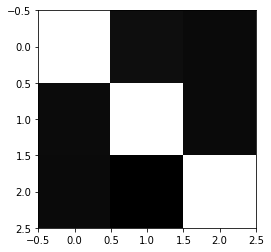

In [0]:
#fitting the model

train(train_X, train_Y, negative_train_Y, Epoch)

#Print the result

generated_image = generator(train_X_temp, training=True)

plt.imshow(generated_image[0,:,:,0], cmap='gray')

print(generated_image[0,:,:,0])


In [0]:
print([3**-1])


print(generator)

[0.3333333333333333]
